# Deep Learning for Text

## Introduction


One of the most succesful tasks Deep Learning has been able to tackle is **Natural Language Processing**. In short, the goal here is, using machine learning and large datasets, to give computers the ability to ingest a piece of language as input and return something useful, like predicting:
- "What’s the topic of this text?" (text classification)
- "Does this text contain abuse?" (content filtering)
- "Does this text sound positive or negative?" (sentiment analysis)
- "What should be the next word in this incomplete sentence?" (language modeling)
- "How would you say this in German?" (translation)
- "How would you summarize this article in one paragraph?" (summarization)

In this notebook we will look at a dataset of song lyrics and will train models that will predict the genre of the song among three possible options: Rock, Pop, and Hip-Hop. This correspond to a classification task. 

We will cover how to preprocess the text using **standarization** and **tokenization**. Then, we will think on how to represent the words in a way that can be understood by a Deep Learning model. We'll talk about **one-hot encoding** and **word embeddings**, and we will also introduce **bag-of-words** using unigrams and bigrams.



## Text Preprocessing Fundamentals



Let us first understand how to encode text into something that can be processed by a deep-learning model.

**Vectorizing** text is the proces of transforming text into numeric tensors. The process is as follows:
1. Standarize: Remove punctuation, convert to lowercase etc.
2. Tokenize: Split the text into units (called "tokens"), such as characters or words or group of words.
3. Third, convert each token into a numerical vector. This will usually involve first indexing all tokens present in the data.

The first process is fairly standard and we won't consider any variations of it.

For tokenization, we will consider splitting into words. We will begin with **unigrams**, which means that we will consider each word separately. We will move later to consider **bigrams**, where the tokens will be all words and pair of consecutives words in the text. We'll see how this adds valuable context to our model.

We will begin by processing text as a set (bag) of tokens (words or group of words in our case). This is the simplest way to encode a piece of text.

You could either look at individual words (**unigrams**), or try to recover some local order information by looking at groups of consecutive token (**N-grams**).

For example, the sentence "the cat sat on the mat" becomes:

Using a bag of single words:
`{"cat", "mat", "on", "sat", "the"}`

With bigrams: `{"the", "the cat", "cat", "cat sat", "sat",
 "sat on", "on", "on the", "the mat", "mat"}`

In the case of vectorization, we will also consider different schemas. First, we will work with a binary representation of words called **one-hot encoding**, where each word is associated to a vector as large as the vocabulary size, and the entry will take value 0 or 1 depending if that word is present in the text or not. A next step will be to store not the presence, but the count of each word. Finally, we'll present a more sophisticated approach called **embedding**, where we represent words by real value dense vectors. In this case, the size of the vector will be smaller than the size of the vocabulary. Once we get to there we'll explain this in more detail.

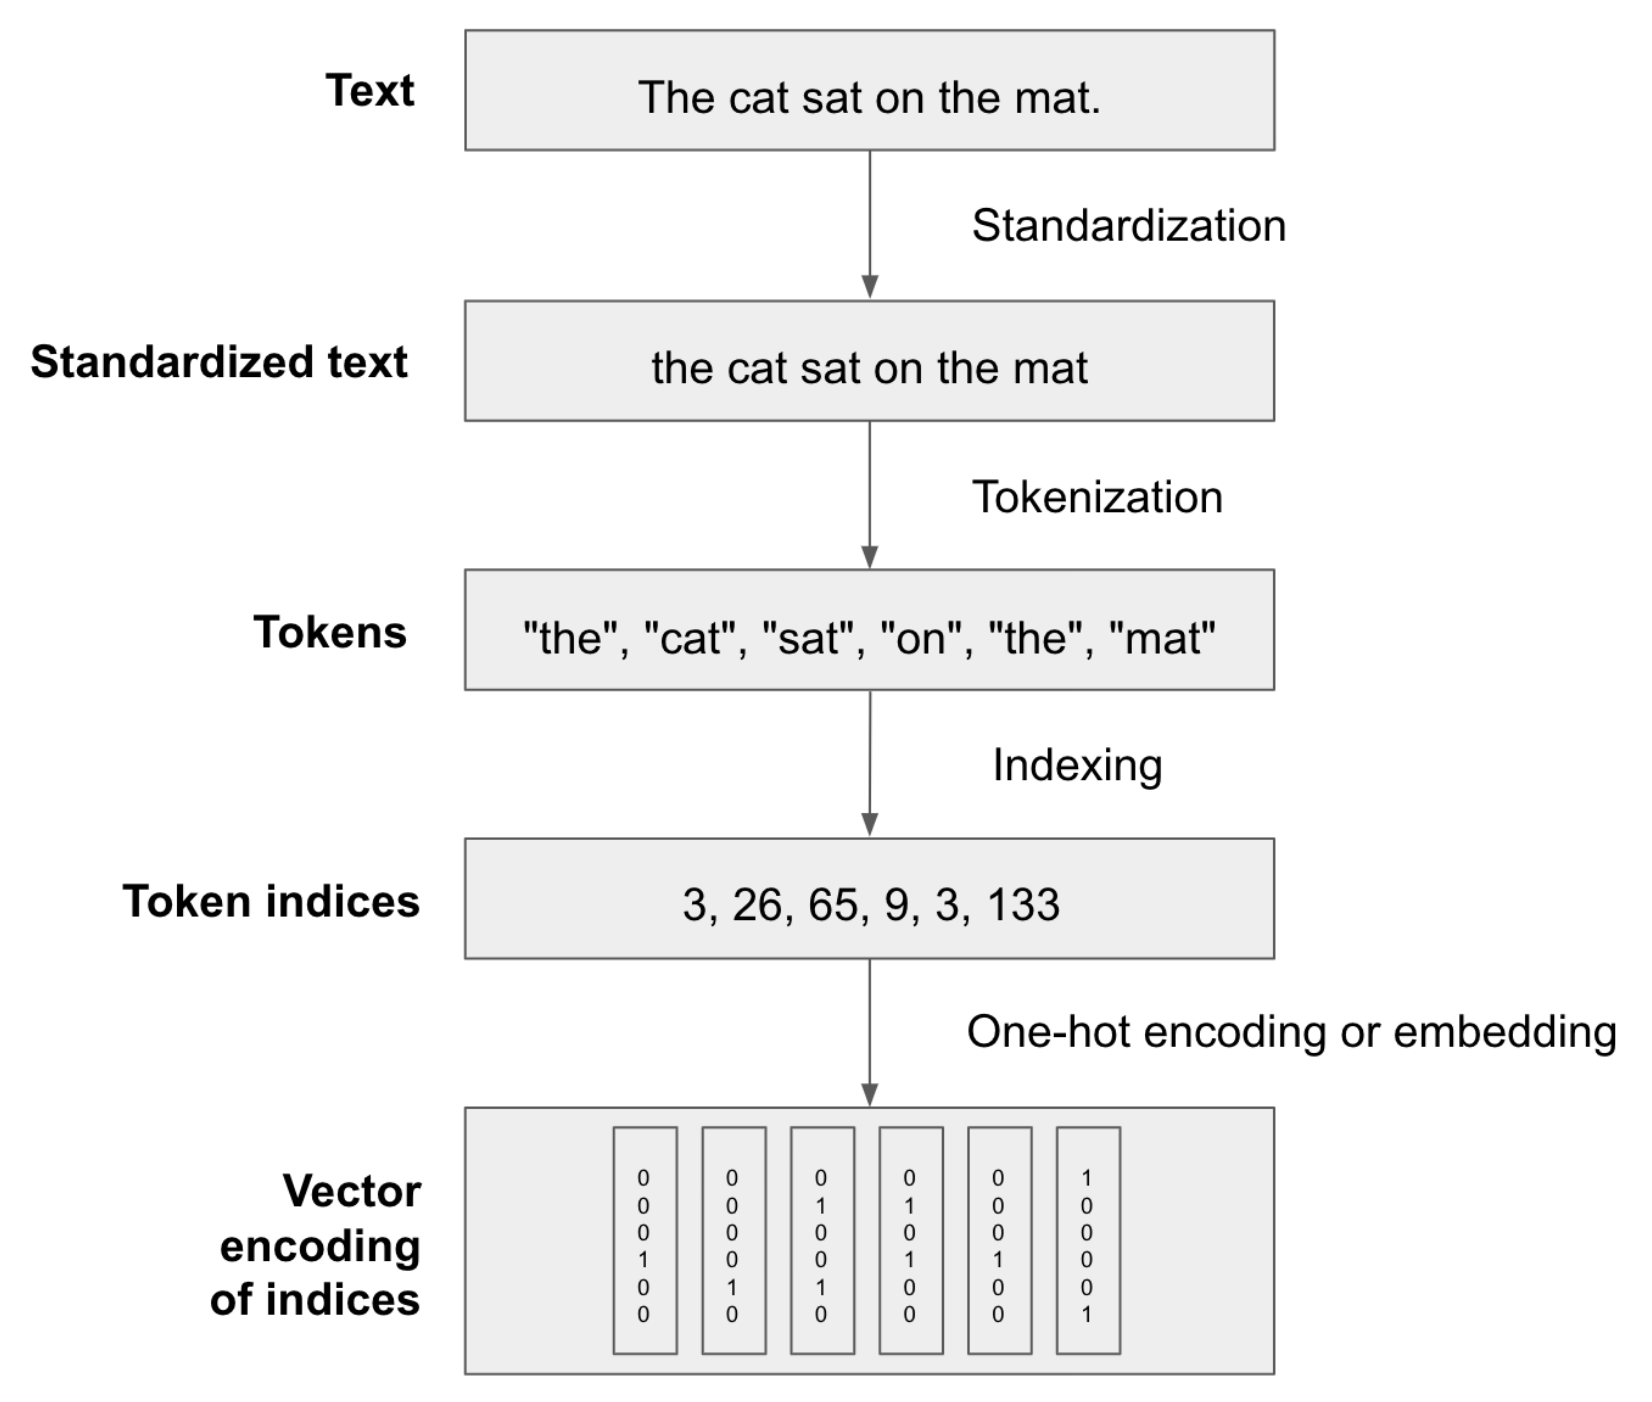
This seems like a lot, right?

Luckily for us, Keras has its own module that performs the three tasks above in a efficient and simple way using the `TextVectorization` layer.


## The TextVectorization Layer

Usual technical preliminaries ...

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

keras.utils.set_random_seed(42)

The following line "configures" a TextVectorization layer by telling it how we want the STIE process - Standardize, Tokenize, Index, Encode - to be done.


In this example, 
- we use the default standarization which will remove punctuation and covert to lowercase. 
- we use the default tokenization at a word level, by setting `split='whitespace'`. 
- we set the output mode to `int` to indicate that we stop with just the index and not do any encoding for the moment. 

In [ ]:
text_vectorization = keras.layers.TextVectorization(
    output_mode = 'int',   
    standardize='lower_and_strip_punctuation',
    split='whitespace'
)

Now that the layer has been configured, we have to run it on a bunch of text to "populate" it.

We use the `adapt()` method for this.



In [ ]:
dataset = [
    "I write, erase, rewrite",
    "Erase again, and then",
    "A poppy blooms.",
    "Hola! are you laid-back in Mexico"
]

# Index vocabulary of the text
text_vectorization.adapt(dataset)


Once we do that, we can use `get_vocabulary()` to see what exactly has been done.


In [ ]:
# Retrieve the vocabulary
vocabulary = text_vectorization.get_vocabulary()
print('Vocabulary:')
print(vocabulary)


Vocabulary:
['', '[UNK]', 'erase', 'you', 'write', 'then', 'rewrite', 'poppy', 'mexico', 'laidback', 'in', 'i', 'hola', 'blooms', 'are', 'and', 'again', 'a']



**Note:** When the output mode is 'int', the vocabulary will  index at 0 the null character `''`, and at 1 the `'[UNK]'` symbol which will be used for any word not present in the vocabulary.


Now that we have configured and populated the `TextVectorization` layer, we can run any sentence through it easily.

In [ ]:
# Encode and decode an example sentence
test_sentence = "I write, rewrite, and still rewrite again"
encoded_sentence = text_vectorization(test_sentence)
print(encoded_sentence)


tf.Tensor([11  4  6 15  1  6 16], shape=(7,), dtype=int64)


We can see that the index 1 appears in the vector above. Recall that 1 stands for "unknown" i.e., [UNK]. 

**Why does 1 show up above?**



We can run this in reverse to confirm this.

In [ ]:
inverse_vocab = dict(enumerate(vocabulary))
decoded_sentence = " ".join(inverse_vocab[int(i)] for i in encoded_sentence)
print(decoded_sentence)

i write rewrite and [UNK] rewrite again


In the spirit of "make small changes to the code to really understand what's going on" ...

What do you think `text_vectorization("Sloan, HODL, DMD")` will be represented as?

<pre>















</pre>


In [ ]:
text_vectorization("Sloan, HODL, DMD")

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([1, 1, 1])>

Good, it is all 1s! Because these words weren't present in the text we used to populate the layer.


Now that we understand how the vectorization works, we will use the `TextVectorization` layer everytime we want to convert text into readable input for our Deep Learning Model.

## Retrieving and preparing the Data



We will work with a dataset that contains the lyrics of almost 90K different songs and its corresponding main genre.

You can find the data in the file `lyric_genre.csv` after downloading it.

Let's inspect it first!


In [ ]:
# Read data from URL

train_df = pd.read_csv('https://www.dropbox.com/s/l583jx2774t6qqd/lyric_genre_train.csv?dl=1', index_col=0).astype(str)
test_df = pd.read_csv('https://www.dropbox.com/s/b7j8lgrehd2ix0d/lyric_genre_test.csv?dl=1', index_col=0).astype(str)
val_df = pd.read_csv('https://www.dropbox.com/s/hb4em4bepnbobev/lyric_genre_val.csv?dl=1', index_col=0).astype(str)

print(f"""
Train samples: {train_df.shape[0]}
Validation samples: {val_df.shape[0]}
Test samples: {test_df.shape[0]}
""")


Train samples: 48991
Validation samples: 16331
Test samples: 21774



In [ ]:
train_df.head()

,Lyric,Genre
0,"Oh, girl. I can't get ready (Can't get ready f...",Pop
1,We met on a rainy evening in the summertime. D...,Pop
2,We carried you in our arms. On Independence Da...,Rock
3,I know he loved you. A long time ago. I ain't ...,Pop
4,Paralysis through analysis. Yellow moral uncle...,Rock


In [ ]:
train_df.tail()

,Lyric,Genre
48986,"[Hook]. Beamer, Benz, Or Bentley. Beamer, Benz...",Hip Hop
48987,You never listen to me. I know I'm better off ...,Pop
48988,Things have come to a pretty pass. Our romance...,Pop
48989,"Little baby, on my shoulder. I could fall into...",Pop
48990,Music : Rudolf Schenker. Lyrics: Klaus Meine. ...,Rock


In [ ]:
# Let's check the proportion of each label on training

train_df['Genre'].value_counts() / train_df.shape[0]

Rock       0.549448
Pop        0.295136
Hip Hop    0.155416
Name: Genre, dtype: float64

One thing we need to do before is to convert the `Genre` column into a dummy variable (one-hot encoding). This is because our task will try to predict to which of the 3 categories the song belongs to, and we have to encode this in a way that can be understood by the Neural Network.

In [ ]:
# Let's turn the target into a dummy vector

y_train = pd.get_dummies(train_df['Genre']).to_numpy()
y_val = pd.get_dummies(val_df['Genre']).to_numpy()
y_test = pd.get_dummies(test_df['Genre']).to_numpy()

In [ ]:
y_train

array([[0, 1, 0],
       [0, 1, 0],
       [0, 0, 1],
       ...,
       [0, 1, 0],
       [0, 1, 0],
       [0, 0, 1]], dtype=uint8)

Let us build now a model that distinguishes the genre from the lyric!

## Baseline Model (Bag of Words)




We will begin by building the simplest model we could come up with: 
- We will tokenize at a word level, and each token will be exactly one word (unigram)
- We will use the one-hot encoding that converts each token into a binary vector indicating the presence of the token. Note that when we tokenize at a word level and use a one-hot encoding to indicate the presence (or as we will see later, the count of the word), the model is called **bag of words**.
- `max_tokens` defines the size of the vocabulary the layer is allowed to construct. If the number of tokens in the `adapt` dataset exceeds this number, the layer will choose the `max_tokens` most frequent tokens and ignore the rest.

In [ ]:
# First, we set up our Text Vectorization layer using multi-hot encoding

max_tokens = 5000  
text_vectorization = keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="multi_hot")


In [ ]:
# The vocabulary that will be indexed is given by the text corpus on our train dataset
text_vectorization.adapt(train_df['Lyric'])

Let's look at the 20 least common words in our vectorization.

In [ ]:
text_vectorization.get_vocabulary()[-20:]

['eden',
 'dagger',
 'curve',
 'cheddar',
 'brew',
 'appears',
 'vacant',
 'universal',
 'unholy',
 'terrified',
 'stickin',
 'rumble',
 'rug',
 'pam',
 'os',
 'ooohh',
 'motto',
 'marshall',
 'loyalty',
 'legacy']

In [ ]:
# We vectorize our input

X_train = text_vectorization(train_df['Lyric'])
X_val = text_vectorization(val_df['Lyric'])
X_test = text_vectorization(test_df['Lyric'])

**Question:**

Each phrase is now a vector. How long is this vector?

<pre>








</pre>

Answer: It is `max_tokens` long i.e., 5000.

In [ ]:
X_train

<tf.Tensor: shape=(48991, 5000), dtype=float32, numpy=
array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]], dtype=float32)>

We can think of this matrix as a sequence of row vectors. Each row vector is one of the ~49K songs in our training data, and each entry of this vector indicates the presence of the word that is indexed in that position. For example, the second entry in all the vectors corresponds to the word 'the' and a 1 indicates the presence of that word in the song.

Let's try a simple 1-hidden layer NN with just 8 neurons in the hidden layer.

In [ ]:
inputs = keras.Input(shape=(max_tokens, ))
x = keras.layers.Dense(8, activation="relu")(inputs)
outputs = keras.layers.Dense(3, activation="softmax")(x)

model = keras.Model(inputs, outputs)

model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 5000)]            0         
                                                                 
 dense_12 (Dense)            (None, 8)                 40008     
                                                                 
 dense_13 (Dense)            (None, 3)                 27        
                                                                 
Total params: 40,035
Trainable params: 40,035
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
# Fit model

model.fit(x=X_train, y=y_train,
          validation_data=(X_val, y_val),
          epochs=10,
          batch_size=32)

Epoch 1/10
1531/1531 [==============================] - 5s 3ms/step - loss: 0.6288 - accuracy: 0.7268 - val_loss: 0.5761 - val_accuracy: 0.7510
Epoch 2/10
1531/1531 [==============================] - 4s 3ms/step - loss: 0.5302 - accuracy: 0.7725 - val_loss: 0.5805 - val_accuracy: 0.7498
Epoch 3/10
1531/1531 [==============================] - 5s 3ms/step - loss: 0.4977 - accuracy: 0.7842 - val_loss: 0.5928 - val_accuracy: 0.7437
Epoch 4/10
1531/1531 [==============================] - 4s 3ms/step - loss: 0.4738 - accuracy: 0.7955 - val_loss: 0.6018 - val_accuracy: 0.7458
Epoch 5/10
1531/1531 [==============================] - 4s 3ms/step - loss: 0.4521 - accuracy: 0.8044 - val_loss: 0.6239 - val_accuracy: 0.7442
Epoch 6/10
1531/1531 [==============================] - 4s 3ms/step - loss: 0.4327 - accuracy: 0.8120 - val_loss: 0.6503 - val_accuracy: 0.7417
Epoch 7/10
1531/1531 [==============================] - 4s 3ms/step - loss: 0.4129 - accuracy: 0.8209 - val_loss: 0.6701 - val_accuracy:

In [ ]:
model.evaluate(x=X_test, y=y_test)

681/681 [==============================] - 1s 2ms/step - loss: 0.7894 - accuracy: 0.7302


[0.7893946766853333, 0.7301827669143677]

Note that the largest class is Rock, with around 58%, so a dummy predictor that outputs the most common class would get 58% accuracy. 

Our simple 1-hidden layer NN using unigrams and multi-hot encoding improves on that nicely!!


## Word Embeddings




It seems that adding the count of words didn't help us that much.

Crucially, when you encode something via one-hot encoding, you’re making a feature-engineering decision that assummes that the different tokens you’re encoding are all independent from each other: indeed, one-hot vectors are all orthogonal to one another. 

In the case of words, that assumption is clearly wrong. Words form a structured space: they share information with each other. The words "movie" and "film" are interchangeable in most sentences, so the vector that represents "movie" should not be orthogonal to the vector that represents "film"—they should be the same vector, or close enough.

Word embeddings are **vector representations** of words that achieve exactly this: they map human language into a structured geometric space.


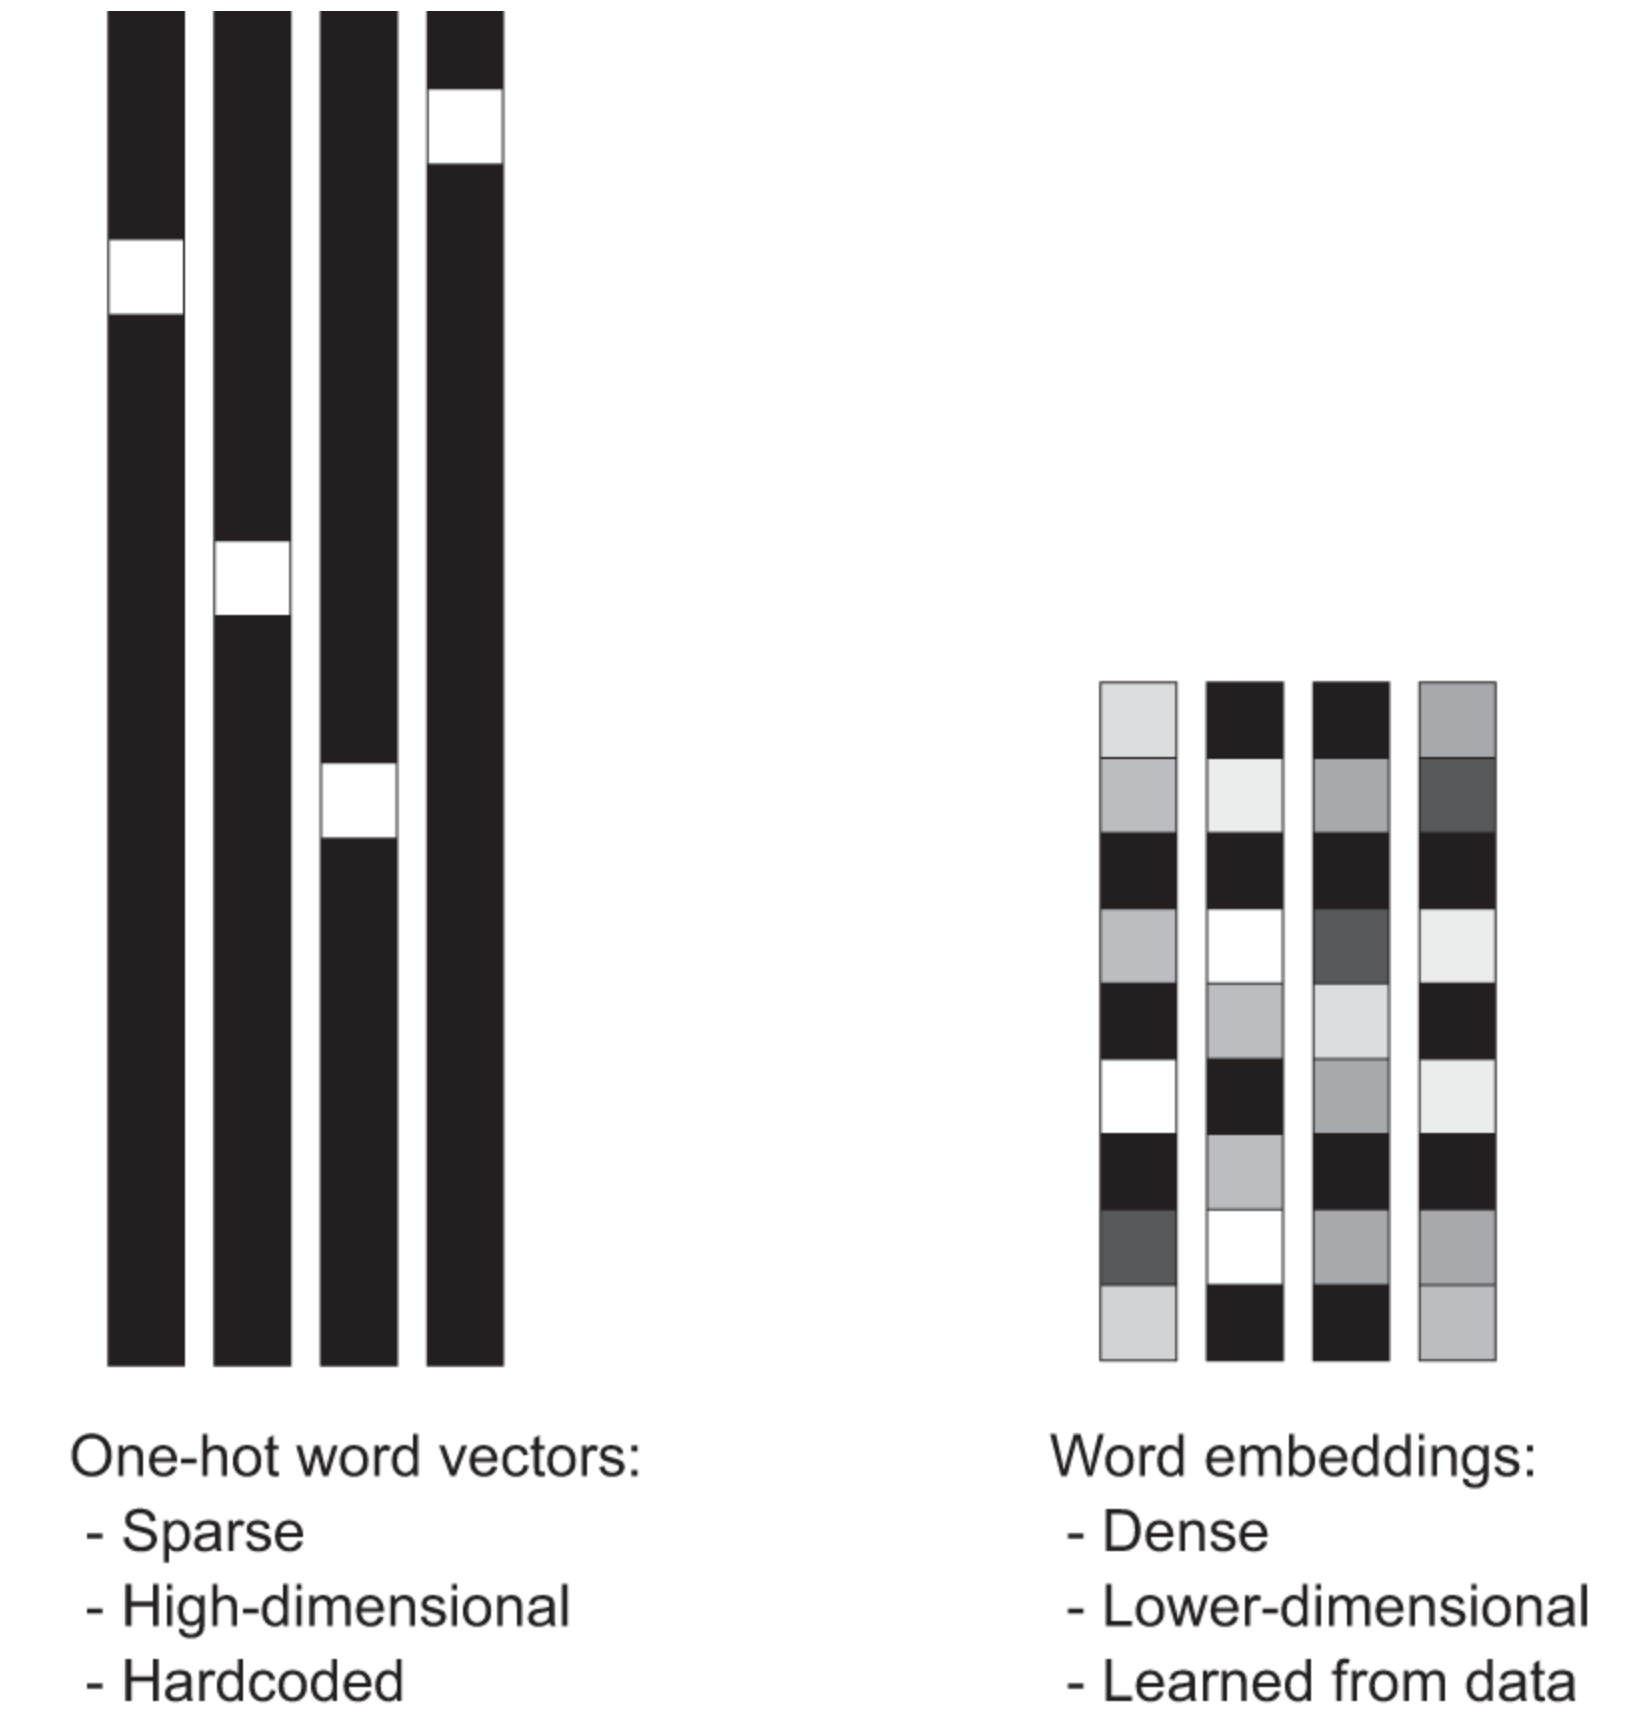

Ideally, word embeddings will try to convey meaning within the geometric space in which the words are represented. For example, a potential representation could have the following structure:

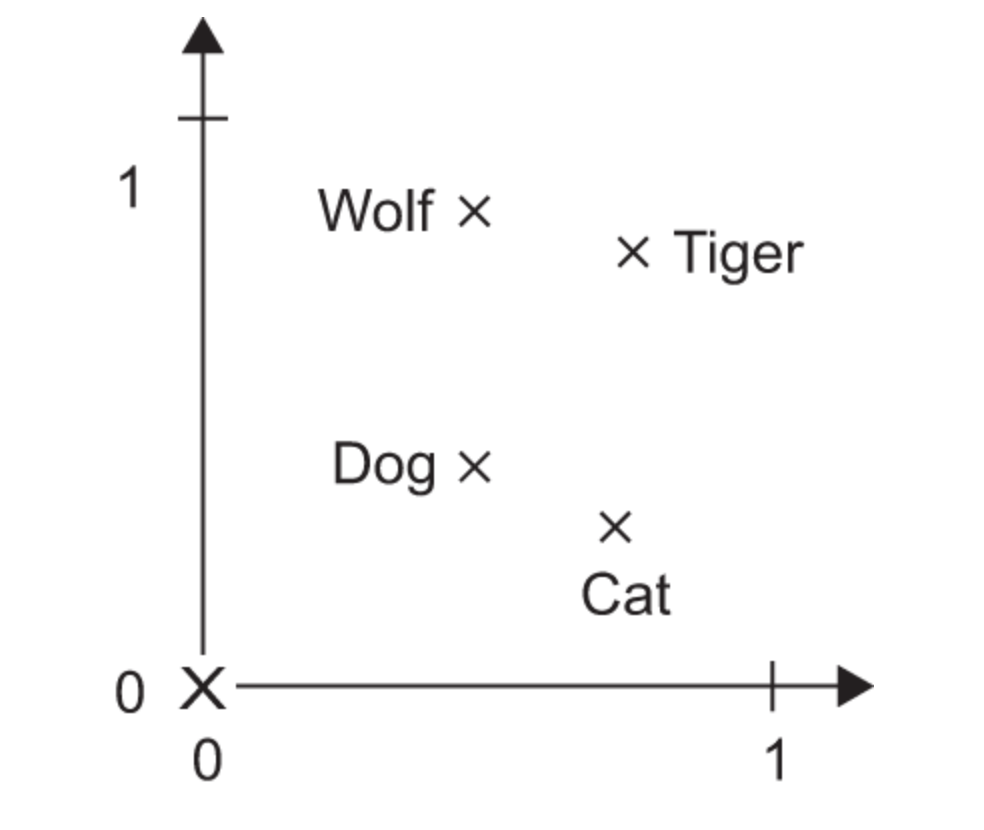

You see the relation between Dog and Wolf with Cat and Tiger? A good embedding should be able to capture these type of semantic meaning.

In real-world word-embedding spaces, common examples of meaningful geometric transformations are "gender" vectors and "plural" vectors. For instance, by adding a "female" vector to the vector "king," we obtain the vector "queen." By adding a "plural" vector, we obtain "kings." Word-embedding spaces typically feature thousands of such interpretable and potentially useful vectors.

Where do we get these word embeddings from? We have two options: we can learn them from our data, or insert a previously trained embedding into our model.

Let's now take the second route and use an **already trained word embedding**. This can be useful if you don't have enough data to learn a task-specific embedding of your vocabulary.

It has the drawback that this embedding will not be customized to your data, but they capture generic aspects of language structure. This is not necessarily bad since one would expect that in most cases word features to be fairly generic.

There are a couple of popular word embeddings that you can download and use in a Keras `Embedding` layer (Word2Vec, GloVe). 

Let's look at an example using GloVe which was precomputed on the 2014 English Wikipedia dataset. 

We first begin by downloading the GloVe word embedding  that contains 100-dimensional embedding vectors of 400,000 words.

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2022-04-16 13:00:28--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-04-16 13:00:28--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-04-16 13:00:29--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
embedding_dim = 100
path_to_glove_file = f"glove.6B.{embedding_dim}d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


Let's take a look at some word vectors.

In [ ]:
embeddings_index["movie"] 

array([ 0.38251  ,  0.14821  ,  0.60601  , -0.51533  ,  0.43992  ,
        0.061053 , -0.62716  , -0.025385 ,  0.1643   , -0.22101  ,
        0.14423  , -0.37213  , -0.21683  , -0.08895  ,  0.097904 ,
        0.6561   ,  0.64455  ,  0.47698  ,  0.83849  ,  1.6486   ,
        0.88922  , -0.1181   , -0.012465 , -0.52082  ,  0.77854  ,
        0.48723  , -0.014991 , -0.14127  , -0.34747  , -0.29595  ,
        0.1028   ,  0.57191  , -0.045594 ,  0.026443 ,  0.53816  ,
        0.32257  ,  0.40788  , -0.043599 , -0.146    , -0.48346  ,
        0.32036  ,  0.55086  , -0.76259  ,  0.43269  ,  0.61753  ,
       -0.36503  , -0.60599  , -0.79615  ,  0.3929   , -0.23668  ,
       -0.34719  , -0.61201  ,  0.54747  ,  0.94812  ,  0.20941  ,
       -2.7771   , -0.6022   ,  0.8495   ,  1.2549   ,  0.017893 ,
       -0.041901 ,  2.1147   , -0.026618 , -0.28104  ,  0.68124  ,
       -0.14165  ,  0.99249  ,  0.49879  , -0.67538  ,  0.6417   ,
        0.42303  , -0.27913  ,  0.063403 ,  0.68909  , -0.3618

In [ ]:
embeddings_index["film"] 

array([ 0.19916 , -0.049702,  0.24579 , -0.32281 ,  0.89768 , -0.1278  ,
       -0.49506 ,  0.20814 , -0.20046 , -0.20604 ,  0.038292, -0.67277 ,
       -0.12689 , -0.18766 , -0.10277 ,  0.73128 ,  0.82408 ,  0.087288,
        0.69255 ,  1.3107  ,  0.49113 , -0.38097 ,  0.24338 , -0.27813 ,
        0.62506 ,  0.35978 ,  0.42041 , -0.24529 ,  0.14861 , -0.26726 ,
       -0.56262 ,  0.63843 , -0.54153 ,  0.36537 ,  0.20545 , -0.16604 ,
        0.72434 ,  0.29961 , -0.42501 , -0.35932 , -0.089288,  0.48752 ,
       -1.0927  ,  0.88818 ,  0.89941 , -0.7541  , -0.35492 , -0.76396 ,
        0.27468 ,  0.2757  , -0.48152 , -0.41399 ,  0.64489 ,  1.148   ,
       -0.29131 , -2.9387  , -0.83162 ,  0.95586 ,  1.1623  , -0.42502 ,
        0.15486 ,  2.2326  , -0.31339 , -0.030228,  0.79802 , -0.41302 ,
        0.72885 ,  0.7296  , -0.31909 ,  0.8956  ,  0.34625 ,  0.2923  ,
        0.40056 ,  0.78985 , -0.43999 ,  0.24698 , -0.46548 ,  0.055886,
       -0.62603 , -0.036487, -0.65429 ,  0.10563 , 

Let's now load the GloVe embeddings into the model and train it!

In [ ]:
max_length = 300 #90% of songs
max_tokens = 5000

text_vectorization = keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)

We haven't seen the `output_sequence_length` argument before. This is what it does (iPad).

In [ ]:
text_vectorization.adapt(train_df['Lyric'])

In [ ]:
X_train = text_vectorization(train_df['Lyric'])
X_val = text_vectorization(val_df['Lyric'])
X_test = text_vectorization(test_df['Lyric'])

To add a word embedding to our model, we can use a Keras layer called `Embedding` and incorporate it as an extra layer of our Neural Network.

The Embedding layer is best understood as a dictionary that maps integer indices (which stand for specific words) to dense vectors. It takes integers as input, looks up these integers in an internal dictionary, and returns the associated vectors. It’s effectively a dictionary lookup.

The Embedding layer takes as input a rank-2 tensor of integers, of shape (batch_size, sequence_length), where each entry is a sequence of integers. The layer then returns a 3D floating-point tensor of shape (batch_size, sequence_length, embedding_ dimensionality).

**SWITCH TO IPAD**

When you instantiate an Embedding layer, its weights (its internal dictionary of token vectors) are initially random, just as with any other layer. During training, these word vectors are gradually adjusted via gradient descent (i.e., backpropagation).

Since we want to use the downloaded GLoVE embeddings, we will first build a matrix of shape `(max_words, embedding_dim)` and fix it as the embeddings of the `Embedding` layer. 

We will add an extra argument `trainable=False` to freeze the layer to avoid disrupting these pretrained GLoVE embeddings during training.

In [ ]:
vocabulary = text_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary))))

counter = 0
embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        counter += 1


The above code creates a lookup table that maps integers to the corresponding word vectors

In [ ]:
embedding_matrix.shape

(5000, 100)

We can now feed this matrix as the initial weights of the `Embedding` layer.


The first argument of the method corresponds to the number of possible tokens, and the second is the dimension of the geometrical space where we will represent our words. 

In [ ]:
embedding_layer = keras.layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer= keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [ ]:
print(f'There are {counter} words on our vocabulary not present in the Glove embedding')
print(f'This is roughly {counter / max_tokens * 100:.2f}% of the vocabulary')
print('These words will be represented by a vector of 0 in all entries in the embedding')

There are 155 words on our vocabulary not present in the Glove embedding
This is roughly 3.10% of the vocabulary
These words will be represented by a vector of 0 in all entries in the embedding


We can now build a Neural Network with an embedding layer after its input layer. This layer will use the already computed Glove embeddings to convert each word in the document into a dense vector. Thus, each text will be represented by a matrix.

How do we convert this matrix in something that can be used as a vector that can be fed to the next Dense layer of the network? There are actually many answers to this, but the approach we will take will be to take the average of the vectors of each word in the text, and that will be the representation of the review in the embedded space. We  use the `GlobalAveragePooling1D` layer ([link](https://keras.io/api/layers/pooling_layers/global_average_pooling1d/)) layer for this purpose.

**SWITCH TO IPAD TO EXPLAIN VISUALLY HOW THIS WORKS**






In [ ]:
inputs = keras.Input(shape=(max_length,))
embedded = embedding_layer(inputs) # 300 x 100 table comes out
embedded = keras.layers.GlobalAveragePooling1D()(embedded) # 100-element vector 
x = keras.layers.Dense(8)(embedded)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(3, activation="softmax")(x)

model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding (Embedding)       (None, 300, 100)          500000    
                                                                 
 global_average_pooling1d (G  (None, 100)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 8)                 808       
                                                                 
 dropout (Dropout)           (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 3)                 27        
                                                             

In [ ]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
# Fit model

model.fit(x=X_train, y=y_train,
          validation_data=(X_val, y_val),
          epochs=10,
          batch_size=32,)

Epoch 1/10
1531/1531 [==============================] - 7s 3ms/step - loss: 0.8846 - accuracy: 0.5945 - val_loss: 0.7947 - val_accuracy: 0.6388
Epoch 2/10
1531/1531 [==============================] - 4s 3ms/step - loss: 0.8079 - accuracy: 0.6380 - val_loss: 0.7614 - val_accuracy: 0.6711
Epoch 3/10
1531/1531 [==============================] - 4s 3ms/step - loss: 0.7963 - accuracy: 0.6430 - val_loss: 0.7522 - val_accuracy: 0.6757
Epoch 4/10
1531/1531 [==============================] - 4s 3ms/step - loss: 0.7928 - accuracy: 0.6466 - val_loss: 0.7492 - val_accuracy: 0.6751
Epoch 5/10
1531/1531 [==============================] - 4s 3ms/step - loss: 0.7892 - accuracy: 0.6501 - val_loss: 0.7576 - val_accuracy: 0.6606
Epoch 6/10
1531/1531 [==============================] - 4s 3ms/step - loss: 0.7870 - accuracy: 0.6505 - val_loss: 0.7432 - val_accuracy: 0.6764
Epoch 7/10
1531/1531 [==============================] - 4s 3ms/step - loss: 0.7819 - accuracy: 0.6545 - val_loss: 0.7452 - val_accuracy:

In [ ]:
model.evaluate(x=X_test, y=y_test)

681/681 [==============================] - 1s 2ms/step - loss: 0.7682 - accuracy: 0.6666


[0.7682338953018188, 0.6665748357772827]

You’ll find that on this particular task, pretrained embeddings aren’t very helpful, because the dataset contains enough samples that it is possible to learn a pretty enough specialized embedding space from scratch. However, leveraging pretrained embeddings can be very helpful when you’re working with a smaller dataset.

Remember how we had set the `trainable` parameter to `False` when setting the embedding layer? What would happen if we change this?

One can think in the Embedding layer as taking the vectorized representation of words and adding weights to each component to form a new vector in a lower dimensional space. These weights are fixed and come from the Glove embedding. But since the Embedding layer is just another layer in our Neural Network, we could update those weights with gradient descent. 

Let's try that out!


In [ ]:
embedding_layer = keras.layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=True,
)

inputs = keras.Input(shape=(max_length,))
embedded = embedding_layer(inputs)
embedded = keras.layers.GlobalAveragePooling1D()(embedded)  
x = keras.layers.Dense(8)(embedded)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(3, activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding_1 (Embedding)     (None, 300, 100)          500000    
                                                                 
 global_average_pooling1d_1   (None, 100)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 8)                 808       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_3 (Dense)             (None, 3)                 27        
                                                           

In [ ]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])


In [ ]:
# Fit model
model.fit(x=X_train, y=y_train,
          validation_data=(X_val, y_val),
          epochs=10,
          batch_size=32,)

Epoch 1/10
1531/1531 [==============================] - 6s 4ms/step - loss: 0.7850 - accuracy: 0.6556 - val_loss: 0.6665 - val_accuracy: 0.7153
Epoch 2/10
1531/1531 [==============================] - 5s 3ms/step - loss: 0.6774 - accuracy: 0.7106 - val_loss: 0.6296 - val_accuracy: 0.7285
Epoch 3/10
1531/1531 [==============================] - 5s 3ms/step - loss: 0.6448 - accuracy: 0.7255 - val_loss: 0.6127 - val_accuracy: 0.7368
Epoch 4/10
1531/1531 [==============================] - 5s 3ms/step - loss: 0.6261 - accuracy: 0.7328 - val_loss: 0.6138 - val_accuracy: 0.7387
Epoch 5/10
1531/1531 [==============================] - 5s 3ms/step - loss: 0.6126 - accuracy: 0.7381 - val_loss: 0.6219 - val_accuracy: 0.7303
Epoch 6/10
1531/1531 [==============================] - 5s 3ms/step - loss: 0.5992 - accuracy: 0.7457 - val_loss: 0.6120 - val_accuracy: 0.7361
Epoch 7/10
1531/1531 [==============================] - 5s 3ms/step - loss: 0.5863 - accuracy: 0.7492 - val_loss: 0.6233 - val_accuracy:

In [ ]:
model.evaluate(x=X_test, y=y_test)

681/681 [==============================] - 1s 2ms/step - loss: 0.6452 - accuracy: 0.7328


[0.6451812386512756, 0.732754647731781]

Nice improvement! 

Let's run the model on a lyric fragment and see what it predicts. We will create a little helper function to make life easier.

In [ ]:
def lyric_predict(phrase):
    raw_text_data = tf.convert_to_tensor([[phrase],])

    vect_data = text_vectorization(raw_text_data)
    predictions = model.predict(vect_data) 
    predictions
    print(f"{float(predictions[0,0] * 100):.2f} % Hip-Hop")
    print(f"{float(predictions[0,1] * 100):.2f} % Pop")
    print(f"{float(predictions[0,2] * 100):.2f} % Rock")

In [ ]:
phrase = '''I'm bringing sexy back Them other boys don't know how to 
act I think you're special, what's behind your back? So turn around and 
I'll pick up the slack'''

lyric_predict(phrase)

1.89 % Hip-Hop
19.01 % Pop
79.10 % Rock


**What's your favorite song? Let's run it through the model!**

In [ ]:
lyric_predict('''I walked through the door with you
The air was cold
But something about it felt like home somehow
And I, left my scarf there at your sister's house
And you've still got it in your drawer even now
Oh, your sweet disposition
And my wide-eyed gaze
We're singing in the car, getting lost upstate
Autumn leaves falling down like pieces into place
And I can picture it after all these days
And I know it's long gone and that magic's not here no more
And I might be okay but I'm not fine at all
'Cause there we are again on that little town street
You almost ran the red 'cause you were lookin' over at me
Wind in my hair, I was there
I remember it all too well
Photo album on the counter
Your cheeks were turning red
You used to be a little kid with glasses in a twin-sized bed
And your mother's telling stories 'bout you on the tee-ball team
You told me 'bout your past thinking your future was me
And I know it's long gone and there was nothing else I could do
And I forget about you long enough to forget why I needed to
'Cause there we are again in the middle of the night
We're dancing 'round the kitchen in the refrigerator light
Down the stairs, I was there
I remember it all too well, yeah
And maybe we got lost in translation
Maybe I asked for too much
But maybe this thing was a masterpiece 'til you tore it all up
Running scared, I was there
I remember it all too well
And you call me up again just to break me like a promise
So casually cruel in the name of being honest
I'm a crumpled up piece of paper lying here
'Cause I remember it all, all, all
Too well
Time won't fly, it's like I'm paralyzed by it
I'd like to be my old self again
But I'm still trying to find it
After plaid shirt days and nights when you made me your own
Now you mail back my things and I walk home alone
But you keep my old scarf from that very first week
'Cause it reminds you of innocence
And it smells like me
You can't get rid of it
'Cause you remember it all too well, yeah
'Cause there we are again when I loved you so
Back before you lost the one real thing you've ever known
It was rare, I was there, I remember it all too well
Wind in my hair, you were there, you remember it all
Down the stairs, you were there, you remember it all
It was rare, I was there, I remember it all too well''')

3.33 % Hip-Hop
48.05 % Pop
48.61 % Rock



So it seems that using the information from the text to further adjust the weights of the pretrained embedding helps. Why not just learn an embedding from scratch then? 

We can easily do this by adding a fresh Embedding layer to the net, specifying in this case what the output dimension will be (the size of the embedding space).

In [ ]:
inputs = keras.Input(shape=(max_length,))

embedded = keras.layers.Embedding(input_dim=max_tokens, 
                                  output_dim=64, )(inputs)

embedded = keras.layers.GlobalAveragePooling1D()(embedded) 

x = keras.layers.Dense(32)(embedded)

x = keras.layers.Dropout(0.5)(x)

outputs = keras.layers.Dense(3, activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 300)]             0         
                                                                 
 embedding_2 (Embedding)     (None, 300, 64)           320000    
                                                                 
 global_average_pooling1d_2   (None, 64)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 3)                 99        
                                                           

In [ ]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
model.fit(x=X_train, y=y_train,
          validation_data=(X_val, y_val),
          epochs=10,
          batch_size=32,)   

Epoch 1/10
1531/1531 [==============================] - 6s 4ms/step - loss: 0.6986 - accuracy: 0.7036 - val_loss: 0.6162 - val_accuracy: 0.7349
Epoch 2/10
1531/1531 [==============================] - 5s 3ms/step - loss: 0.5995 - accuracy: 0.7493 - val_loss: 0.6092 - val_accuracy: 0.7387
Epoch 3/10
1531/1531 [==============================] - 5s 3ms/step - loss: 0.5709 - accuracy: 0.7613 - val_loss: 0.6116 - val_accuracy: 0.7382
Epoch 4/10
1531/1531 [==============================] - 5s 3ms/step - loss: 0.5527 - accuracy: 0.7676 - val_loss: 0.6197 - val_accuracy: 0.7351
Epoch 5/10
1531/1531 [==============================] - 5s 3ms/step - loss: 0.5403 - accuracy: 0.7720 - val_loss: 0.6263 - val_accuracy: 0.7368
Epoch 6/10
1531/1531 [==============================] - 5s 3ms/step - loss: 0.5326 - accuracy: 0.7769 - val_loss: 0.6347 - val_accuracy: 0.7312
Epoch 7/10
1531/1531 [==============================] - 5s 3ms/step - loss: 0.5257 - accuracy: 0.7786 - val_loss: 0.6404 - val_accuracy:

In [ ]:
model.evaluate(x=X_test, y=y_test)

681/681 [==============================] - 1s 2ms/step - loss: 0.6736 - accuracy: 0.7277


[0.6736411452293396, 0.727748692035675]

Accuracy remains at about the same, but notice that we only had to train this network once, and the number of trainable parameters is much lower.

In many situations though, using a pretrained embedding can be beneficial, specially if we don't have a lot of data.


## Adding Context with Bigrams



We're basically at 73% accuracy at this point!

Can we do any better? Is there any aspect of the text that we're failing to capture with all the models we've seen so far?

Suppose we're trying to predict the sentiment of a movie review that looks something like this:

"Kate Winslet's performance as a detective trying to solve a terrible crime in a small Pennsylvania town is anything but dissapointing."

How would this be interpreted by our models that look at each word *separately*? Notice the words "terrible" and "dissapointing". These are words that carry a negative sentiment if looked out of context. However, by looking at the words sorrounding them ("terrible crime", "anything but dissapointing"), one can immediately notice that the first one is not a description of the quality of the movie, and the second one is actually a positive review.

Although is easy for us to realize this, how can we make our models more context aware? As the example above suggests, we can look at words as groups instead of single entities. One way to do this is to change the way we do the Tokenization, and instead of picking words one by one, we can also pick pairs or more consecutive words.

Let's start using bigrams, which will use pair of *consecutive* words as the level of tokenization to add more context to our models. 

The reason why we would like to do this is that discarding word order is very reductive, and because even atomic concepts can be expressed via multiple words: the term "United States" conveys a concept that is quite distinct from the meaning of the words "states" and "united" taken separately. For this reason, you will usually end up re-injecting local order information into your bag-of-words representation by looking at N-grams rather than single words (most commonly, bigrams).



Let's warm up with a simple example.

In [ ]:
# Text Vectorization layer using bigrams
text_vectorization = keras.layers.TextVectorization(
    ngrams=2,    
    output_mode="multi_hot")

In [ ]:
text_vectorization.adapt(["the cat sat on a mat."])

In [ ]:
text_vectorization.get_vocabulary()

['[UNK]',
 'the cat',
 'the',
 'sat on',
 'sat',
 'on a',
 'on',
 'mat',
 'cat sat',
 'cat',
 'a mat',
 'a']

See how bigrams are generated? Now back to the original problem.

In [ ]:
# Text Vectorization layer using bigrams

text_vectorization = keras.layers.TextVectorization(
    ngrams=2,    
    max_tokens=20000,
    output_mode="multi_hot",
)

In [ ]:
# We encode the dictionary using the train data
text_vectorization.adapt(train_df['Lyric'])

Let's see what the first and last 10 items in the vocabulary are.

In [ ]:
text_vectorization.get_vocabulary()[-10:]

['8x',
 '44',
 'you’re a',
 'your mom',
 'your god',
 'you shot',
 'you hell',
 'you far',
 'ya all',
 'x6']

In [ ]:
X_train = text_vectorization(train_df['Lyric'])
X_val = text_vectorization(val_df['Lyric'])
X_test = text_vectorization(test_df['Lyric'])

In [ ]:
inputs = keras.Input(shape=(20000,))
x = keras.layers.Dense(8, activation="relu")(inputs)
x = keras.layers.Dropout(0.5)(x)
outputs = keras.layers.Dense(3, activation="softmax")(x)

model = keras.Model(inputs, outputs)
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 20000)]           0         
                                                                 
 dense_20 (Dense)            (None, 8)                 160008    
                                                                 
 dropout_7 (Dropout)         (None, 8)                 0         
                                                                 
 dense_21 (Dense)            (None, 3)                 27        
                                                                 
Total params: 160,035
Trainable params: 160,035
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

In [ ]:
# Fit model
model.fit(x=X_train, y=y_train,
          validation_data=(X_val, y_val),
          epochs=3,
          batch_size=32)

Epoch 1/3
1531/1531 [==============================] - 6s 4ms/step - loss: 0.7513 - accuracy: 0.6558 - val_loss: 0.6047 - val_accuracy: 0.7376
Epoch 2/3
1531/1531 [==============================] - 6s 4ms/step - loss: 0.6347 - accuracy: 0.7251 - val_loss: 0.5750 - val_accuracy: 0.7538
Epoch 3/3
1531/1531 [==============================] - 6s 4ms/step - loss: 0.5819 - accuracy: 0.7512 - val_loss: 0.5777 - val_accuracy: 0.7544


In [ ]:
model.evaluate(x=X_test, y=y_test)

681/681 [==============================] - 2s 3ms/step - loss: 0.5890 - accuracy: 0.7462


[0.5890359282493591, 0.746211051940918]

**Our test accuracy increased from 73% for unigrams to 74.6% for bigrams!**

This improvement highlights the importance of local word order in understanding the context of a text. 


Let's try the model on a couple of new sentences.

In [ ]:
phrase = '''I walked through the door with you
The air was cold
But something about it felt like home somehow
And I, left my scarf there at your sister's house
And you've still got it in your drawer even now
Oh, your sweet disposition
And my wide-eyed gaze
We're singing in the car, getting lost upstate
Autumn leaves falling down like pieces into place
And I can picture it after all these days
And I know it's long gone and that magic's not here no more
And I might be okay but I'm not fine at all
'Cause there we are again on that little town street
You almost ran the red 'cause you were lookin' over at me
Wind in my hair, I was there
I remember it all too well
Photo album on the counter
Your cheeks were turning red
You used to be a little kid with glasses in a twin-sized bed
And your mother's telling stories 'bout you on the tee-ball team
You told me 'bout your past thinking your future was me
And I know it's long gone and there was nothing else I could do
And I forget about you long enough to forget why I needed to
'Cause there we are again in the middle of the night
We're dancing 'round the kitchen in the refrigerator light
Down the stairs, I was there
I remember it all too well, yeah
And maybe we got lost in translation
Maybe I asked for too much
But maybe this thing was a masterpiece 'til you tore it all up
Running scared, I was there
I remember it all too well
And you call me up again just to break me like a promise
So casually cruel in the name of being honest
I'm a crumpled up piece of paper lying here
'Cause I remember it all, all, all
Too well
Time won't fly, it's like I'm paralyzed by it
I'd like to be my old self again
But I'm still trying to find it
After plaid shirt days and nights when you made me your own
Now you mail back my things and I walk home alone
But you keep my old scarf from that very first week
'Cause it reminds you of innocence
And it smells like me
You can't get rid of it
'Cause you remember it all too well, yeah
'Cause there we are again when I loved you so
Back before you lost the one real thing you've ever known
It was rare, I was there, I remember it all too well
Wind in my hair, you were there, you remember it all
Down the stairs, you were there, you remember it all
It was rare, I was there, I remember it all too well'''

lyric_predict(phrase)

0.00 % Hip-Hop
72.39 % Pop
27.61 % Rock


Now, you're probably thinking: let's mix this with our word embedding approach to get an even more powerful representation that captures context! And then, let's use 3-grams instead of bigrams! No, even better, 4-grams or 5-grams!

Although your intuition might be the correct, when adding more and more context in the form of grams, the number of parameters increases exponentially.

In the next class, we will learn another class of models that can take in to account a broader context withouth increasing sustantially the number of parameters and the size of our models.

## Conclusions



- We studied a genre clasification task.
- We learned different ways of how to represent text as numerical vectors that can be fed to a neural network structure.
- We learned about word embeddings, including pretrained ones like Glove, and how to train your own word embeddings.
- We saw how adding context to the word representation can increase the accuracy of our models.